In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# download data
api = KaggleApi()
api.authenticate()
#api.dataset_download_files('sanikamal/horses-or-humans-dataset', path="data/", unzip=True)

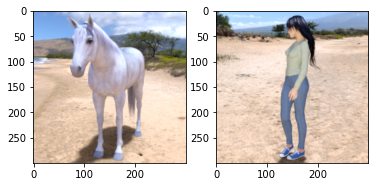

In [3]:
img1 = mpimg.imread("data/horse-or-human/train/horses/horse01-0.png")
img2 = mpimg.imread("data/horse-or-human/train/humans/human01-00.png")
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img1)
ax2.imshow(img2)

In [4]:
img1.shape # This is RGB-A so it has 4 channels

(300, 300, 4)

In [47]:
# classify data
train_data_gen = ImageDataGenerator(rescale=1/255)
train_dir = "data/horse-or-human/train"
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(300,300), 
    batch_size=128,
    class_mode="binary"
)

Found 1027 images belonging to 2 classes.


target size resizes images as they are loaded so you dont need to preprocess all your images before feeding them in.

the train test is done in batches to make it more efficient


In [48]:
test_data_gen = ImageDataGenerator(rescale=1/255)
test_dir = "data/horse-or-human/validation"
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(300,300), 
    batch_size=128,
    class_mode="binary"
)

Found 256 images belonging to 2 classes.


In [7]:
train_generator.image_shape # will be transformed to RGB

(300, 300, 3)

In [42]:
# set up the model
model = tf.keras.models.Sequential([
    # convolutions
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Hidden layers
    tf.keras.layers.Dense(512, activation="relu"),
    # Output layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 64)       

In [52]:
class AccuracyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.99): 
      print("\nReached 99% accuracy. Cancelling training!")
      self.model.stop_training = True

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), # how do we choose learning rate?
              metrics=['accuracy'])

We have 1027 train images (500 horse and 527 human), these are split into batches of size 128. 

In each epoch, we will go through all the training images. That means it will take 8 batches of size 128 to complete an epoch. 

In [53]:
model.fit(
    train_generator, 
    steps_per_epoch=8,
    epochs = 15,
    verbose=1,
    callbacks=[AccuracyCallback()]
)

Epoch 1/15
8/8 [==============================] - 22s 3s/step - loss: 0.2582 - accuracy: 0.9188
Epoch 2/15
8/8 [==============================] - 21s 3s/step - loss: 0.0241 - accuracy: 0.9933

Reached 99% accuracy. Cancelling training!


In [54]:
model.evaluate(test_generator)

2/2 [==============================] - 2s 647ms/step - loss: 0.7177 - accuracy: 0.9141


[0.7177392244338989, 0.9140625]

Horse


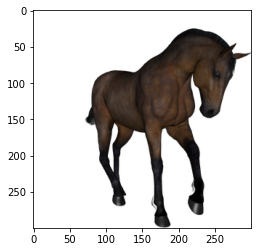

In [81]:
# test on validation data
# model.input_shape (None, 300, 300, 3)
path = "data/horse-or-human/"
img = load_img(path+'validation/horses/horse1-000.png', target_size=(300, 300))
img_as_array = img_to_array(img)
# img_as_array.shape
plt.imshow(img)
prediction = model.predict(img_as_array.reshape(1,300,300,3))
if prediction[0][0] < .5:
    print("Horse")
else:
    print("Human")

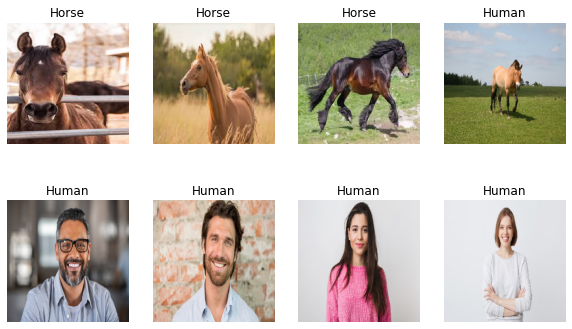

In [123]:
# test on real worl data
fig, ax = plt.subplots(2,4, figsize=[10,6])
img_dir = os.listdir(path+"test")

for i in range(len(img_dir)):
    img = load_img(path+"test/"+img_dir[i], target_size=(300, 300))
    prediction = model.predict(img_to_array(img).reshape(1,300,300,3)/255)
    if prediction[0][0] < .5:
        Label = "Horse"
    else:
        Label = "Human"
    if i < 4:
        ax[0,i].imshow(img)
        ax[0,i].axis('Off')
        ax[0,i].title.set_text(Label)
    else:
        ax[1,i-4].imshow(img)
        ax[1,i-4].axis('Off')
        ax[1,i-4].title.set_text(Label)
   


In [124]:
# visualising intermediate representations

human_img = img_to_array(load_img(path+"train/humans/"+os.listdir(path+"train/humans")[0], target_size=(300, 300))).reshape(1,300, 300, 3)
horse_img = img_to_array(load_img(path+"train/horses/"+os.listdir(path+"train/horses")[0], target_size=(300, 300))).reshape(1,300, 300, 3)
human_img /= 255
horse_img /= 255
outputs = [layer.output for layer in model.layers]
#visualization_model = Model(img_input, outputs) # what is this?
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

successive_feature_maps_human = visualization_model.predict(human_img)
successive_feature_maps_horse = visualization_model.predict(horse_img)

layer_names = [layer.name for layer in model.layers]

C:\Users\sherv\Anaconda3\envs\ML-Projects\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


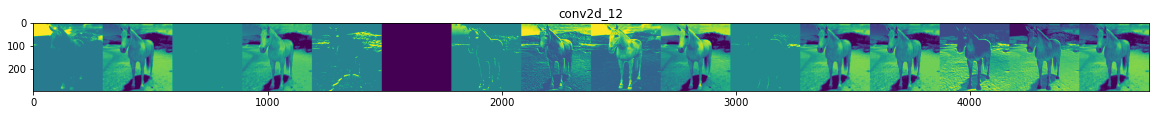

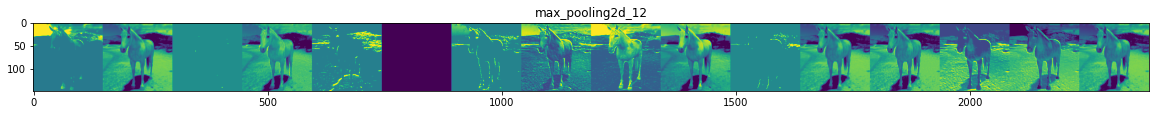

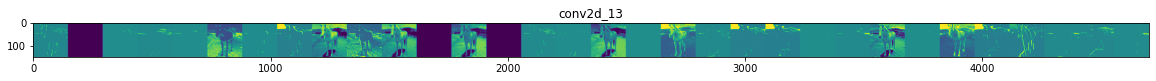

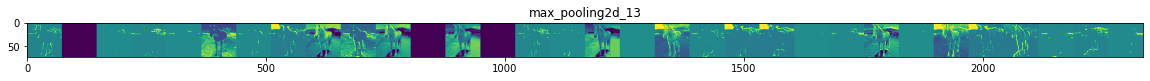

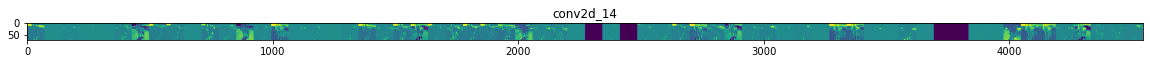

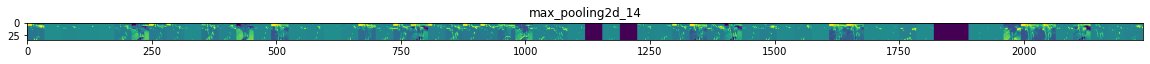

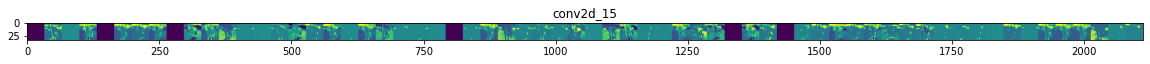

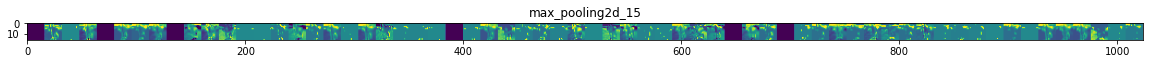

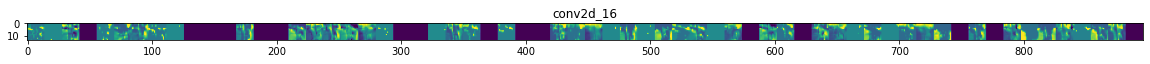

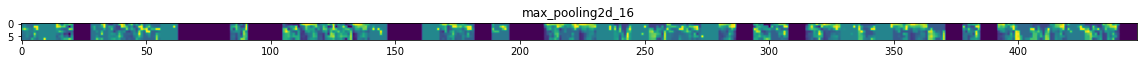

In [127]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps_horse):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
        # Postprocess the feature to make it visually palatable
            horse_img = feature_map[0, :, :, i]
            horse_img -= horse_img.mean()
            horse_img /= horse_img.std()
            horse_img *= 64
            horse_img += 128
            horse_img = np.clip(horse_img, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = horse_img
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

C:\Users\sherv\Anaconda3\envs\ML-Projects\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


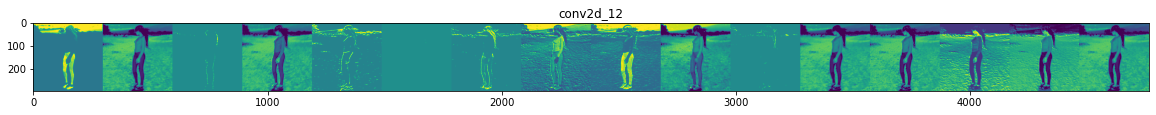

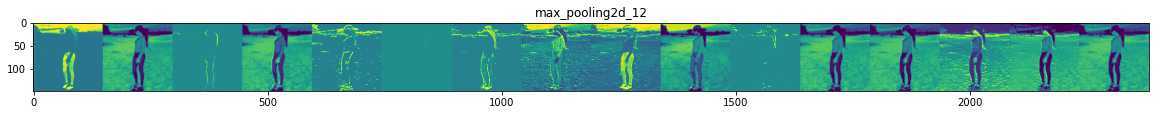

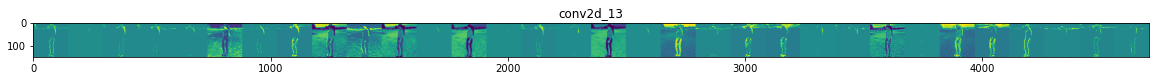

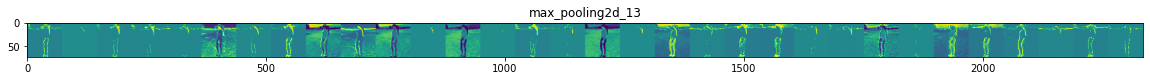

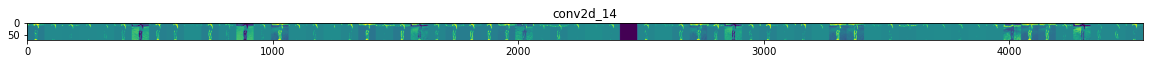

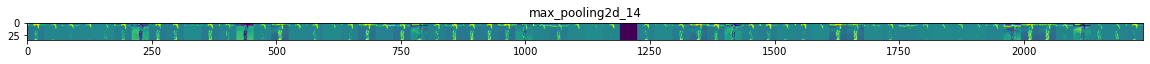

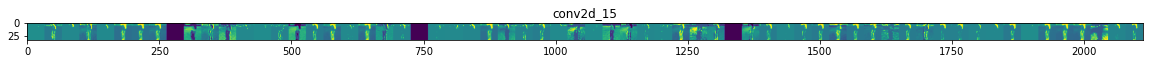

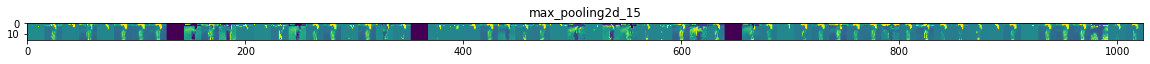

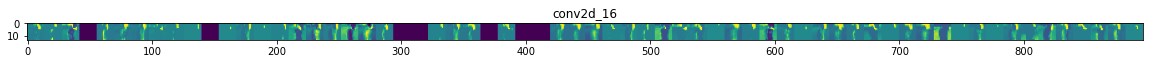

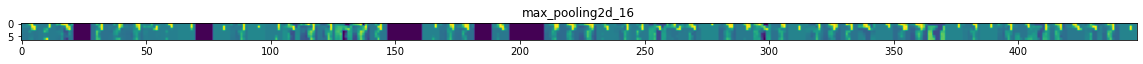

In [128]:
for layer_name, feature_map in zip(layer_names, successive_feature_maps_human):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
        # Postprocess the feature to make it visually palatable
            human_img = feature_map[0, :, :, i]
            human_img -= human_img.mean()
            human_img /= human_img.std()
            human_img *= 64
            human_img += 128
            human_img = np.clip(human_img, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = human_img
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')